<a href="https://colab.research.google.com/github/IyadKhuder/BioInfo/blob/main/expend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Expenditure Model**

Analyze how updating model parameters defined by Ministry of Internal Affairs and communication www.mpsv.cz, will impact expenditure model outcome compared to current parameters. In addition, analyze how this will inturn impact the limit issued

### Importing the libraries

In [ ]:
# Defining some variables
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# The old accommodation cost dictionaries
OWNERS_WITH_COUNT_OF_ROOMMATES = {1: 4670, 2: 6661, 3: 9050, 4: 11268}

RENT_COST_WITH_COUNT_OF_ROOMMATES = {
    1: {1: 8233, 2: 11444, 3: 15288, 4: 18805},
    2: {1: 6541, 2: 9129, 3: 12260, 4: 15154},
    3: {1: 6233, 2: 8708, 3: 11710, 4: 14491},
    4: {1: 5314, 2: 7450, 3: 10065, 4: 12507},
    5: {1: 5117, 2: 7180, 3: 9712, 4: 12082}
}

# The new accommodation cost dictionaries
# Based on this reference:
# https://www.zakonyprolidi.cz/cs/1995-117

OWNERS_WITH_COUNT_OF_ROOMMATES_N = {1: 8932, 2: 8932, 3: 11161, 4: 13568}

RENT_COST_WITH_COUNT_OF_ROOMMATES_N = {
    1: {1: 16729, 2: 16729, 3: 19212, 4: 23195},
    2: {1: 14197, 2: 14197, 3: 15900, 4: 19202},
    3: {1: 13737, 2: 13737, 3: 15299, 4: 18477}
}


In [ ]:
# Global Constants

# The already-existing expenditures:
EXPENDITURE_ALONE = 3860
EXPENDITURE_WITH_ANOTHER = 3550
EXPENDITURE_WITH_ADULT = 3200
EXPENDITURE_WITH_ANOTHER_CHILD = 2420
EXPENDITURE_WITH_PARTNER_FEMALE = 0.4
EXPENDITURE_WITH_PARTNER_MALE = 0.6

STUDENT_RENT_FREE_AGE = 26

FLOOR_EXPENSES_FOR_STUDENTS = 8000
CEIL_EXPENSES_MATERNITY_LEAVES = 35000


# The up-to-date expenditures:
# https://www.mpsv.cz/web/cz/zivotni-a-existencni-minimum
EXPENDITURE_ALONE_N = 4860
EXPENDITURE_WITH_ANOTHER_N = 4470
EXPENDITURE_WITH_ADULT_N = 4040
EXPENDITURE_WITH_ANOTHER_CHILD_N = 2480
EXPENDITURE_WITH_PARTNER_FEMALE_N = 0.4
EXPENDITURE_WITH_PARTNER_MALE_N = 0.6

STUDENT_RENT_FREE_AGE_N = 26

FLOOR_EXPENSES_FOR_STUDENTS_N = 8000
CEIL_EXPENSES_MATERNITY_LEAVES_N = 35000

In [ ]:
# Income types:
INCOME_CEC_EMPLOYMENT = 1
INCOME_CEC_PENSION = 2
INCOME_CEC_MATERNITY = 3
INCOME_CEC_SELF_EMPLOYMENT = 4
INCOME_CEC_WELFARE = 5
INCOME_CEC_OTHER = 6
INCOME_CEC_STUDENT = 7

In [ ]:
INCOME_TYPES_COEF = {
    INCOME_CEC_EMPLOYMENT: 1.1 * 1.5,
    INCOME_CEC_PENSION: 1.2 * 1.5,
    INCOME_CEC_MATERNITY: 1.3 * 1.5,
    INCOME_CEC_SELF_EMPLOYMENT: 1.0 * 1.5,
    INCOME_CEC_WELFARE: 1.0 * 1.5,
    INCOME_CEC_OTHER: 1.5 * 1.5,
    INCOME_CEC_STUDENT: 1.0 * 1.5,
}

In [ ]:
# Define the city population ranges and types
CITY_TYPE_XXL = 1  # More than 1000 000
CITY_TYPE_XL = 2  # 100 000 - 1000 000
CITY_TYPE_L = 3  # 50 000 - 99 999
CITY_TYPE_M = 4  # 10 000 - 49 000
CITY_TYPE_S = 5  # less than 10 000

PRAGUE_BRNO = 1  # Prague / Brno
MIDDLE_CITY = 2  # 70 000 - 400 000
SMALL_CITY = 3  # up to 400 001

CITY_POPULATION_RANGES = {
    CITY_TYPE_XXL: (1000000, 10000000),
    CITY_TYPE_XL: (100000, 999999),
    CITY_TYPE_L: (50000, 99999),
    CITY_TYPE_M: (10000, 49999),
    CITY_TYPE_S: (0, 9999)
}

CITY_POPULATION_RANGES_N = {
    PRAGUE_BRNO: (400001, 10000000),
    MIDDLE_CITY: (70000, 400000),
    SMALL_CITY: (0, 69999)
}

###  *Connecting to Google-Drive and importing the dataset file*

In [ ]:
# libraries for the files in google drive
from pydrive2.auth import GoogleAuth
from google.colab import drive
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Import the CSV dataset from Google Drive:
download = drive.CreateFile({'id': '10TovtoOf7kqG0kxBqZlqHAEmWBp1tDz9'})

# 5k: 10Y4MZc4taOD1xV1ZBKlO04gJXn0XDBp_
# 50k: 10TovtoOf7kqG0kxBqZlqHAEmWBp1tDz9
# Download the file to a local disc
download.GetContentFile('df.csv')


In [ ]:
# Read the CSV file and ensure 'cur_personal_id' is read as a string and 'date_created' is parsed as a datetime
df = pd.read_csv('df.csv', dtype={'cur_personal_id': str}, parse_dates=['date_created'])

# Extract only the year part from the 'date_created' column
df['yr_cr'] = pd.to_datetime(df['date_created']).dt.year
# Extract only the date part from the 'date_created' column
df['date_cr'] = pd.to_datetime(df['date_created']).dt.date

In [ ]:
# Get the list of columns
column_names = list(df.columns)

# Print the list of columns
print(column_names)

['population_total', 'city', 'id', 'income_amount', 'income_type', 'family_type', 'expense_amount', 'expense_debt', 'education_type', 'family_children', 'expenses_total_expert_model', 'upgrade_request_id', 'date_created', 'cur_personal_id', 'yr_cr', 'date_cr']


In [ ]:
BRNO_POPULATION = df[df['city']=='Brno']['population_total'].values[0]
PRAHA_POPULATION = df[df['city']=='Praha']['population_total'].values[0]

In [ ]:
print(BRNO_POPULATION)

378327


In [ ]:
print(f"The population of Brno is: {BRNO_POPULATION}")
print(f"The population of Praha is: {PRAHA_POPULATION}")

The population of Brno is: 378327
The population of Praha is: 1246780


In [ ]:
from IPython.display import display

# Configure the notebook to display all columns in the DataFrame head() output
pd.set_option('display.max_columns', None)


In [ ]:
# Display the first few rows of the updated DataFrame
display(df.head())


,population_total,city,id,income_amount,income_type,family_type,expense_amount,expense_debt,education_type,family_children,expenses_total_expert_model,upgrade_request_id,date_created,cur_personal_id,yr_cr,date_cr
0,1246780,Praha,528100,25000.0,1,1,4000.0,7000.0,5,0,14602,716776,2020-11-18 13:50:47.881998+00:00,8908141363,2020,2020-11-18
1,7644,Vimperk,614971,21000.0,1,2,5000.0,5000.0,4,1,9937,811213,2021-02-28 07:22:56.982827+00:00,7756151634,2021,2021-02-28
2,1246780,Praha,614926,2000.0,1,1,0.0,0.0,4,0,14602,779772,2021-01-25 13:56:02.709391+00:00,9504201180,2021,2021-01-25
3,36401,Třinec,614999,8000.0,7,1,8000.0,0.0,2,0,5790,811241,2021-02-28 08:47:54.947953+00:00,9853134313,2021,2021-02-28
4,24925,Břeclav,547496,13000.0,2,5,8000.0,0.0,2,1,18196,739706,2020-12-14 19:30:13.596866+00:00,6658121547,2020,2020-12-14


In [ ]:
# Change the datatype of 'cur_personal_id' column to string
df['cur_personal_id'] = df['cur_personal_id'].astype(str)


In [ ]:
# Calculate the length of each value in the cur_personal_id column
lengths = df['cur_personal_id'].apply(len)

# Get the unique lengths
unique_lengths = lengths.unique()

# Display the unique lengths
print(unique_lengths)

[10  9]


In [ ]:
# Get the unique lengths and their counts
length_counts = lengths.value_counts()

In [ ]:
print(length_counts)

cur_personal_id
10    49243
9       757
Name: count, dtype: int64


In [ ]:
# Drop rows where the length is less than 5
# df = df[lengths >= 5]

In [ ]:
# Calculate the length of each value in the cur_personal_id column
lengths = df['cur_personal_id'].apply(len)

# Get the unique lengths
unique_lengths = lengths.unique()

# Display the unique lengths
print(unique_lengths)

# Get the unique lengths and their counts
length_counts = lengths.value_counts()

print(length_counts)

[10  9]
cur_personal_id
10    49243
9       757
Name: count, dtype: int64


In [ ]:
print(len(df))

50000


In [ ]:
def get_birthdate(personal_id: str) -> date | None:
    if not personal_id:
        return None

    year = int(personal_id[0:2])
    month = int(personal_id[2:4])
    day = int(personal_id[4:6])

    if len(personal_id) == 9:
        if year >= 54:
            return None

        year += 1900

        if month > 50:
            month -= 50
    else:
        if year < 54:
            year += 2000
        else:
            year += 1900

        if month > 70 and year > 2003:
            month -= 70
        elif month > 50:
            month -= 50
        elif month > 20 and year > 2003:
            month -= 20

    try:
        return date(year, month, day)
    except ValueError:
        return None


In [ ]:
def is_female(personal_id: str) -> int:
    return int(personal_id[2]) >= 5


In [ ]:
is_female('8062115512')

True

In [ ]:
is_female('8062115513')

True

In [ ]:
is_female('806211551')

True

In [ ]:
is_female('80321')

False

In [ ]:
# Create a column for the gender (F/M):
df['is_fem'] = df['cur_personal_id'].apply(is_female)

In [ ]:
per_id = '8062115512'
bd = get_birthdate(per_id)
print(f"The birthdate for {per_id} is: {bd}")

The birthdate for 8062115512 is: 1980-12-11


In [ ]:
per_id = '455214043'
bd = get_birthdate(per_id)
print(f"The birthdate for {per_id} is: {bd}")

The birthdate for 455214043 is: 1945-02-14


In [ ]:
df['birthdate'] = df['cur_personal_id'].apply(get_birthdate)

In [ ]:
display(df.head())

,population_total,city,id,income_amount,income_type,family_type,expense_amount,expense_debt,education_type,family_children,expenses_total_expert_model,upgrade_request_id,date_created,cur_personal_id,yr_cr,date_cr,is_fem,birthdate
0,1246780,Praha,528100,25000.0,1,1,4000.0,7000.0,5,0,14602,716776,2020-11-18 13:50:47.881998+00:00,8908141363,2020,2020-11-18,False,1989-08-14
1,7644,Vimperk,614971,21000.0,1,2,5000.0,5000.0,4,1,9937,811213,2021-02-28 07:22:56.982827+00:00,7756151634,2021,2021-02-28,True,1977-06-15
2,1246780,Praha,614926,2000.0,1,1,0.0,0.0,4,0,14602,779772,2021-01-25 13:56:02.709391+00:00,9504201180,2021,2021-01-25,False,1995-04-20
3,36401,Třinec,614999,8000.0,7,1,8000.0,0.0,2,0,5790,811241,2021-02-28 08:47:54.947953+00:00,9853134313,2021,2021-02-28,True,1998-03-13
4,24925,Břeclav,547496,13000.0,2,5,8000.0,0.0,2,1,18196,739706,2020-12-14 19:30:13.596866+00:00,6658121547,2020,2020-12-14,True,1966-08-12


In [ ]:
def calculate_age(created: date, birthdate: date) -> int:
    # Get the current date
    # today = datetime.today().date()

    # Calculate the difference in years
    age = created.year - birthdate.year

    # Adjust the age if the birthdate has not occurred yet this year
    if (created.month, created.day) < (birthdate.month, birthdate.day):
        age -= 1

    return age

In [ ]:
# Input dates as strings
created_str = '2022-04-13'
birthdate_str = '1990-11-23'

# Convert the strings to date objects
created_date = datetime.strptime(created_str, '%Y-%m-%d').date()
birthdate_date = datetime.strptime(birthdate_str, '%Y-%m-%d').date()

# Call the function with the date objects
age = calculate_age(created_date, birthdate_date)

print(f"Age: {age}")

Age: 31


In [ ]:
def determine_tenant(age: int) -> int:
    return 1 if age < 60 else 0


In [ ]:
# df['age'] = df['birthdate'].apply(calculate_age)

In [ ]:
# Apply the calculate_age function
df['age'] = df.apply(lambda row: calculate_age(row['date_created'], row['birthdate']), axis=1)


In [ ]:
# Create the 'tenant' column based on the age
df['tenant'] = df['age'].apply(determine_tenant)

In [ ]:
def get_city_type(population):
    for city_type, (min_pop, max_pop) in CITY_POPULATION_RANGES.items():
        if min_pop <= population <= max_pop:
            return city_type
    return None  # In case the population doesn't fit any range

In [ ]:
def get_city_type_N(population):
    for city_type_N, (min_pop, max_pop) in CITY_POPULATION_RANGES_N.items():
        if min_pop <= population <= max_pop:
            return city_type_N
    return None  # In case the population doesn't fit any range

In [ ]:
# Create a new column 'city_type' based on the 'population_total' column
df['city_type'] = df['population_total'].apply(get_city_type)
df['city_type_N'] = df['population_total'].apply(get_city_type_N)


In [ ]:
display(df.sample(3))

,population_total,city,id,income_amount,income_type,family_type,expense_amount,expense_debt,education_type,family_children,expenses_total_expert_model,upgrade_request_id,date_created,cur_personal_id,yr_cr,date_cr,is_fem,birthdate,age,tenant,city_type,city_type_N
44909,32823,Cheb,472941,19200.0,1,1,4500.0,2100.0,2,0,11683,645943,2020-07-03 11:02:27.467535+00:00,8155141819,2020,2020-07-03,True,1981-05-14,39,1,4,3
30788,36957,Česká Lípa,1406185,30000.0,6,1,14000.0,1400.0,2,2,28942,1659897,2023-09-03 17:30:27.196951+00:00,8655142529,2023,2023-09-03,True,1986-05-14,37,1,4,3
19445,297421,Ostrava,739633,13000.0,5,1,11000.0,0.0,4,1,18084,944074,2021-07-12 04:41:39.048768+00:00,8251275549,2021,2021-07-12,True,1982-01-27,39,1,2,2


In [ ]:
welknown_czech_cities = [
    "Praha", "Brno", "Ostrava", "Plzeň", "Liberec", "Olomouc",
    "České Budějovice", "Hradec Králové", "Ústí nad Labem", "Pardubice",
    "Zlín", "Havířov", "Kladno", "Most", "Karviná", "Opava",
    "Frýdek-Místek", "Teplice", "Děčín", "Karlovy Vary", "Jihlava",
    "Chomutov", "Prostějov", "Přerov", "Jablonec nad Nisou"
]

In [ ]:
print(len(welknown_czech_cities))

25


In [ ]:
# Filter the DataFrame for the given list of cities
filtered_df = df[df['city'].isin(welknown_czech_cities)]

# Display the resulting DataFrame
print(filtered_df[['city', 'population_total']])

                 city  population_total
0               Praha           1246780
2               Praha           1246780
7             Ostrava            297421
9               Praha           1246780
10              Praha           1246780
...               ...               ...
49993    Karlovy Vary             50172
49994            Most             67490
49997           Praha           1246780
49998         Olomouc             99471
49999  Ústí nad Labem             93747

[20999 rows x 2 columns]


In [ ]:
print(len(filtered_df))

14086


In [ ]:
filtered_df = filtered_df[['city', 'population_total']].drop_duplicates()

In [ ]:
print(len(filtered_df))

26


In [ ]:
# Display the resulting DataFrame
print(filtered_df[['city', 'population_total']])

                    city  population_total
0                  Praha           1246780
7                Ostrava            297421
15                Přerov             44824
17                  Brno            378327
18         Frýdek-Místek             57523
19              Chomutov             49187
22               Teplice             50330
25                  Most             67490
37    Jablonec nad Nisou             45305
52               Jihlava             50598
58               Olomouc             99471
63        Ústí nad Labem             93747
67               Karviná             57842
80        Hradec Králové             93035
103              Liberec            102113
125                Opava             58054
130               Kladno             68551
137            Pardubice             89467
140            Prostějov             44330
150     České Budějovice             93467
154              Havířov             77371
197                Plzeň            167472
231        

In [ ]:
# Define the function to calculate roommates and expenses_adults
def get_rm_ea(row):
    family_children = row['family_children']
    family_type = row['family_type']

    if family_type in [1, 3, 5, 6]:
        roommates_adult = 1

        if family_children > 0:
            expenses_adults = EXPENDITURE_WITH_ANOTHER
            expenses_adults_N = EXPENDITURE_WITH_ANOTHER_N
        else:
            expenses_adults = EXPENDITURE_ALONE
            expenses_adults_N = EXPENDITURE_ALONE_N

    else:
        expenses_adults = EXPENDITURE_WITH_ANOTHER + EXPENDITURE_WITH_ADULT
        expenses_adults_N = EXPENDITURE_WITH_ANOTHER_N + EXPENDITURE_WITH_ADULT_N
        roommates_adult = 2

    roommates = family_children + roommates_adult

    # Setting a ceiling for the value of 'roommates'
    if roommates > 4:
        roommates = 4

    return roommates_adult, roommates, expenses_adults, expenses_adults_N

In [ ]:
# df['roommates'] = df.apply(get_roommates_exa, axis=1)
df[['rm_ad', 'rm', 'exp_ad', 'exp_ad_N']] = df.apply(lambda row: pd.Series(get_rm_ea(row)), axis=1)


In [ ]:
# # Columns to drop
# cols_to_drop = ['rm_ad', 'rm', 'exp_ad', 'exp_ad_N']
# cols_to_drop = ['rm_ad']
# # Drop the columns
# df = df.drop(columns=cols_to_drop)

In [ ]:
display(df.head(2))

,population_total,city,id,income_amount,income_type,family_type,expense_amount,expense_debt,education_type,family_children,expenses_total_expert_model,upgrade_request_id,date_created,cur_personal_id,yr_cr,date_cr,is_fem,birthdate,age,tenant,city_type,city_type_N,rm_ad,rm,exp_ad,exp_ad_N
0,1246780,Praha,528100,25000.0,1,1,4000.0,7000.0,5,0,14602,716776,2020-11-18 13:50:47.881998+00:00,8908141363,2020,2020-11-18,False,1989-08-14,31,1,1,1,1,1,3860,4860
1,7644,Vimperk,614971,21000.0,1,2,5000.0,5000.0,4,1,9937,811213,2021-02-28 07:22:56.982827+00:00,7756151634,2021,2021-02-28,True,1977-06-15,43,1,5,3,2,3,6750,8510


In [ ]:
# Calculate accommodation costs
def get_accommodation_costs(row):
    tenant = row['tenant']
    roommates = row['rm']
    city_type = row['city_type']
    city_type_N = row['city_type_N']

    if tenant == 0:
        # Not a tenant (is an owner)
        accommodation_costs = OWNERS_WITH_COUNT_OF_ROOMMATES.get(roommates, 0)
        accommodation_costs_N = OWNERS_WITH_COUNT_OF_ROOMMATES_N.get(roommates, 0)
    else:
        # Tenant
        city_costs = RENT_COST_WITH_COUNT_OF_ROOMMATES.get(city_type, {})
        city_costs_N = RENT_COST_WITH_COUNT_OF_ROOMMATES_N.get(city_type_N, {})
        accommodation_costs = city_costs.get(roommates, 0)
        accommodation_costs_N = city_costs_N.get(roommates, 0)

    return accommodation_costs, accommodation_costs_N

In [ ]:
# Get the 'accommodation_costs':
# df['accom_costs'] = df.apply(get_accommodation_costs, axis=1)
df[['accom_costs', 'accom_costs_N']] = df.apply(lambda row: pd.Series(get_accommodation_costs(row)), axis=1)


In [ ]:
# # Columns to drop
# cols_to_drop = ['accommodation_costs', 'accommodation_costs_N']

# # Drop the columns
# df = df.drop(columns=cols_to_drop)

In [ ]:
display(df.head())

,population_total,city,id,income_amount,income_type,family_type,expense_amount,expense_debt,education_type,family_children,expenses_total_expert_model,upgrade_request_id,date_created,cur_personal_id,yr_cr,date_cr,is_fem,birthdate,age,tenant,city_type,city_type_N,rm_ad,rm,exp_ad,exp_ad_N,accom_costs,accom_costs_N
0,1246780,Praha,528100,25000.0,1,1,4000.0,7000.0,5,0,14602,716776,2020-11-18 13:50:47.881998+00:00,8908141363,2020,2020-11-18,False,1989-08-14,31,1,1,1,1,1,3860,4860,8233,16729
1,7644,Vimperk,614971,21000.0,1,2,5000.0,5000.0,4,1,9937,811213,2021-02-28 07:22:56.982827+00:00,7756151634,2021,2021-02-28,True,1977-06-15,43,1,5,3,2,3,6750,8510,9712,15299
2,1246780,Praha,614926,2000.0,1,1,0.0,0.0,4,0,14602,779772,2021-01-25 13:56:02.709391+00:00,9504201180,2021,2021-01-25,False,1995-04-20,25,1,1,1,1,1,3860,4860,8233,16729
3,36401,Třinec,614999,8000.0,7,1,8000.0,0.0,2,0,5790,811241,2021-02-28 08:47:54.947953+00:00,9853134313,2021,2021-02-28,True,1998-03-13,22,1,4,3,1,1,3860,4860,5314,13737
4,24925,Břeclav,547496,13000.0,2,5,8000.0,0.0,2,1,18196,739706,2020-12-14 19:30:13.596866+00:00,6658121547,2020,2020-12-14,True,1966-08-12,54,1,4,3,1,2,3550,4470,7450,13737


In [ ]:
x=2.5
x_rounded = int(round(x))
print(x_rounded)

2


In [ ]:
def total_expenses_both(row):
    family_children = row['family_children']
    income_type = row['income_type']
    exp_ad = row['exp_ad']
    exp_ad_N = row['exp_ad_N']
    accom_costs = row['accom_costs']
    accom_costs_N = row['accom_costs_N']
    age = row['age']
    is_female = row['is_fem']
    roommates_adult = row['rm_ad']

    exp_calc = (EXPENDITURE_WITH_ANOTHER_CHILD * family_children + exp_ad)*INCOME_TYPES_COEF[income_type] + accom_costs

    exp_calc_N = (EXPENDITURE_WITH_ANOTHER_CHILD_N * family_children + exp_ad_N) * INCOME_TYPES_COEF[income_type] + accom_costs_N

    if (age is None or age <= STUDENT_RENT_FREE_AGE) and income_type == INCOME_CEC_STUDENT:
        exp_calc = exp_ad * INCOME_TYPES_COEF[income_type]
        exp_calc_N = exp_ad_N * INCOME_TYPES_COEF[income_type]

    if roommates_adult == 2:
        if is_female:
            exp_calc *= EXPENDITURE_WITH_PARTNER_FEMALE
            exp_calc_N *= EXPENDITURE_WITH_PARTNER_FEMALE_N
        else:
            exp_calc *= EXPENDITURE_WITH_PARTNER_MALE
            exp_calc_N *= EXPENDITURE_WITH_PARTNER_MALE_N

    if income_type == INCOME_CEC_MATERNITY:
        if exp_calc > CEIL_EXPENSES_MATERNITY_LEAVES:
            exp_calc = CEIL_EXPENSES_MATERNITY_LEAVES
        if exp_calc_N > CEIL_EXPENSES_MATERNITY_LEAVES:
            exp_calc_N = CEIL_EXPENSES_MATERNITY_LEAVES

    if income_type != INCOME_CEC_STUDENT and exp_calc < FLOOR_EXPENSES_FOR_STUDENTS:
        exp_calc = FLOOR_EXPENSES_FOR_STUDENTS
    if income_type != INCOME_CEC_STUDENT and exp_calc_N < FLOOR_EXPENSES_FOR_STUDENTS_N:
        exp_calc_N = FLOOR_EXPENSES_FOR_STUDENTS_N

    return int(round(exp_calc)), int(round(exp_calc_N))


In [ ]:
df[['exp_calc', 'exp_calc_N']] = df.apply(lambda row: pd.Series(total_expenses_both(row)), axis=1)


In [ ]:
# # Columns to drop
# cols_to_drop = ['exp_calc','exp_calc_N']

# # Drop the columns
# df = df.drop(columns=cols_to_drop)

In [ ]:
df.sample(5)

,population_total,city,id,income_amount,income_type,family_type,expense_amount,expense_debt,education_type,family_children,expenses_total_expert_model,upgrade_request_id,date_created,cur_personal_id,yr_cr,date_cr,is_fem,birthdate,age,tenant,city_type,city_type_N,rm_ad,rm,exp_ad,exp_ad_N,accom_costs,accom_costs_N,exp_calc,exp_calc_N
8723,1246780,Praha,686607,20000.0,1,4,13500.0,2000.0,1,1,12167,888155,2021-05-14 21:41:31.229271+00:00,8362255352,2021,2021-05-14,True,1983-12-25,37,1,1,1,2,3,6750,8510,15288,19212,12167,14938
25532,236,Branišov,674448,16000.0,1,2,2000.0,3000.0,2,2,12482,875297,2021-05-02 06:02:01.122030+00:00,8851171681,2021,2021-05-02,True,1988-01-17,33,1,5,3,2,4,6750,8510,12082,18477,12482,16281
31814,15852,Bílina,544190,55000.0,6,1,0.0,0.0,1,1,20882,727191,2020-12-01 16:15:55.005579+00:00,9603307582,2020,2020-12-01,False,1996-03-30,24,1,4,3,1,2,3550,4470,7450,13737,20882,29374
30127,823,Dolní Hořice,652272,20000.0,1,1,8000.0,0.0,1,0,11486,851273,2021-04-03 16:47:34.245140+00:00,0112090231,2021,2021-04-03,False,2001-12-09,19,1,5,3,1,1,3860,4860,5117,13737,11486,21756
31174,1246780,Praha,493883,60000.0,1,2,10000.0,30000.0,5,0,9032,673470,2020-09-08 17:44:19.183638+00:00,8452189922,2020,2020-09-08,True,1984-02-18,36,1,1,1,2,2,6750,8510,11444,16729,9033,12308


In [ ]:
display(df.head())

,population_total,city,id,income_amount,income_type,family_type,expense_amount,expense_debt,education_type,family_children,expenses_total_expert_model,upgrade_request_id,date_created,cur_personal_id,yr_cr,date_cr,is_F,birthdate,age,tenant,city_type,rm_ad,rm,exp_ad,exp_ad_N,accom_costs,accom_costs_N,exp_tot,exp_tot_N,exp_tot_diff,inc_percent
0,1246780,Praha,528100,25000.0,1,1,4000.0,7000.0,5,0,14602,716776,2020-11-18 13:50:47.881998+00:00,8908141363,2020,2020-11-18,False,1989-08-14,31,1,1,1,1,3860,4860,8233,8233,14602.0,16252.0,1650.0,0.11
1,7644,Vimperk,614971,21000.0,1,2,5000.0,5000.0,4,1,9937,811213,2021-02-28 07:22:56.982827+00:00,7756151634,2021,2021-02-28,True,1977-06-15,43,1,5,2,3,6750,8510,9712,9712,9937.0,11138.2,1201.2,0.12
2,1246780,Praha,614926,2000.0,1,1,0.0,0.0,4,0,14602,779772,2021-01-25 13:56:02.709391+00:00,9504201180,2021,2021-01-25,False,1995-04-20,25,1,1,1,1,3860,4860,8233,8233,14602.0,16252.0,1650.0,0.11
3,36401,Třinec,614999,8000.0,7,1,8000.0,0.0,2,0,5790,811241,2021-02-28 08:47:54.947953+00:00,9853134313,2021,2021-02-28,True,1998-03-13,22,1,4,1,1,3860,4860,5314,5314,5790.0,7290.0,1500.0,0.26
4,24925,Břeclav,547496,13000.0,2,5,8000.0,0.0,2,1,18196,739706,2020-12-14 19:30:13.596866+00:00,6658121547,2020,2020-12-14,True,1966-08-12,54,1,4,1,2,3550,4470,7450,7450,18196.0,19960.0,1764.0,0.10


In [ ]:
# # Columns to drop
# cols_to_drop = ['inc_percent']

# # Drop the columns
# df = df.drop(columns=cols_to_drop)

In [ ]:
# Renaming columns
df.rename(columns={
    'family_children': 'children',
    'expenses_total_expert_model': 'exp_current',
}, inplace=True)


In [ ]:
df['calc_to_current_error'] = df['exp_calc'] - df['exp_current']

In [ ]:
df['new_current_diff']= df['exp_calc_N'] - df['exp_current']

In [ ]:
df['new_current_inc_rate'] = (100*(df['exp_calc_N'] - df['exp_current']) / df['exp_current']).round(2)


In [ ]:
# Get the list of columns
column_names = list(df.columns)

# Print the list of columns
print(column_names)

['population_total', 'city', 'id', 'income_amount', 'income_type', 'family_type', 'expense_amount', 'expense_debt', 'education_type', 'children', 'exp_current', 'upgrade_request_id', 'date_created', 'cur_personal_id', 'yr_cr', 'date_cr', 'is_fem', 'birthdate', 'age', 'tenant', 'city_type', 'city_type_N', 'rm_ad', 'rm', 'exp_ad', 'exp_ad_N', 'accom_costs', 'accom_costs_N', 'exp_calc', 'exp_calc_N', 'calc_to_current_error', 'new_current_diff', 'new_current_inc_rate']


In [ ]:
# Display the updated DataFrame
df.head()

,population_total,city,id,income_amount,income_type,family_type,expense_amount,expense_debt,education_type,children,exp_current,upgrade_request_id,date_created,cur_personal_id,yr_cr,date_cr,is_fem,birthdate,age,tenant,city_type,city_type_N,rm_ad,rm,exp_ad,exp_ad_N,accom_costs,accom_costs_N,exp_calc,exp_calc_N,calc_to_current_error,new_current_diff,new_current_inc_rate
0,1246780,Praha,528100,25000.0,1,1,4000.0,7000.0,5,0,14602,716776,2020-11-18 13:50:47.881998+00:00,8908141363,2020,2020-11-18,False,1989-08-14,31,1,1,1,1,1,3860,4860,8233,16729,14602,24748,0,10146,69.48
1,7644,Vimperk,614971,21000.0,1,2,5000.0,5000.0,4,1,9937,811213,2021-02-28 07:22:56.982827+00:00,7756151634,2021,2021-02-28,True,1977-06-15,43,1,5,3,2,3,6750,8510,9712,15299,9937,13373,0,3436,34.58
2,1246780,Praha,614926,2000.0,1,1,0.0,0.0,4,0,14602,779772,2021-01-25 13:56:02.709391+00:00,9504201180,2021,2021-01-25,False,1995-04-20,25,1,1,1,1,1,3860,4860,8233,16729,14602,24748,0,10146,69.48
3,36401,Třinec,614999,8000.0,7,1,8000.0,0.0,2,0,5790,811241,2021-02-28 08:47:54.947953+00:00,9853134313,2021,2021-02-28,True,1998-03-13,22,1,4,3,1,1,3860,4860,5314,13737,5790,7290,0,1500,25.91
4,24925,Břeclav,547496,13000.0,2,5,8000.0,0.0,2,1,18196,739706,2020-12-14 19:30:13.596866+00:00,6658121547,2020,2020-12-14,True,1966-08-12,54,1,4,3,1,2,3550,4470,7450,13737,18196,26247,0,8051,44.25


In [ ]:
# Rearranging columns
new_order = [
    'population_total', 'city', 'id', 'income_amount', 'income_type', 'family_type', 'expense_amount',
     'expense_debt', 'education_type', 'children', 'upgrade_request_id', 'date_cr', 'yr_cr',
     'cur_personal_id', 'is_fem', 'birthdate', 'age', 'tenant', 'city_type','city_type_N', 'rm_ad', 'rm', 'exp_ad', 'exp_ad_N',
     'accom_costs', 'accom_costs_N', 'exp_current', 'exp_calc', 'calc_to_current_error', 'exp_calc_N', 'new_current_diff', 'new_current_inc_rate'
     ]

# Applying the new column order
df = df[new_order]

In [ ]:
# Display the updated DataFrame
df.head()

,population_total,city,id,income_amount,income_type,family_type,expense_amount,expense_debt,education_type,children,upgrade_request_id,date_cr,yr_cr,cur_personal_id,is_fem,birthdate,age,tenant,city_type,city_type_N,rm_ad,rm,exp_ad,exp_ad_N,accom_costs,accom_costs_N,exp_current,exp_calc,calc_to_current_error,exp_calc_N,new_current_diff,new_current_inc_rate
0,1246780,Praha,528100,25000.0,1,1,4000.0,7000.0,5,0,716776,2020-11-18,2020,8908141363,False,1989-08-14,31,1,1,1,1,1,3860,4860,8233,16729,14602,14602,0,24748,10146,69.48
1,7644,Vimperk,614971,21000.0,1,2,5000.0,5000.0,4,1,811213,2021-02-28,2021,7756151634,True,1977-06-15,43,1,5,3,2,3,6750,8510,9712,15299,9937,9937,0,13373,3436,34.58
2,1246780,Praha,614926,2000.0,1,1,0.0,0.0,4,0,779772,2021-01-25,2021,9504201180,False,1995-04-20,25,1,1,1,1,1,3860,4860,8233,16729,14602,14602,0,24748,10146,69.48
3,36401,Třinec,614999,8000.0,7,1,8000.0,0.0,2,0,811241,2021-02-28,2021,9853134313,True,1998-03-13,22,1,4,3,1,1,3860,4860,5314,13737,5790,5790,0,7290,1500,25.91
4,24925,Břeclav,547496,13000.0,2,5,8000.0,0.0,2,1,739706,2020-12-14,2020,6658121547,True,1966-08-12,54,1,4,3,1,2,3550,4470,7450,13737,18196,18196,0,26247,8051,44.25


In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/df_clean.csv', index=False)

In [ ]:
df_negative_error = df[df['calc_to_current_error'] < -1]

In [ ]:
print(len(df_negative_error))

741


In [ ]:
df_negative_error.sample(5)

,population_total,city,id,income_amount,income_type,family_type,expense_amount,expense_debt,education_type,children,upgrade_request_id,date_cr,yr_cr,cur_personal_id,is_fem,birthdate,age,tenant,city_type,city_type_N,rm_ad,rm,exp_ad,exp_ad_N,accom_costs,accom_costs_N,exp_current,exp_calc,calc_to_current_error,exp_calc_N,new_current_diff,new_current_inc_rate
32856,881,Hrabětice,555808,40000.0,4,2,5000.0,0.0,4,2,748285,2020-12-21,2020,7854184932,True,1978-04-18,42,1,5,3,2,4,6750,8510,12082,18477,11956,11787,-169,15473,3517,29.42
11221,4124,Nová Role,1386701,35000.0,1,1,20000.0,0.0,1,0,1638511,2023-08-06,2023,8701242011,False,1987-01-24,36,1,5,3,1,1,3860,4860,5117,13737,11683,11486,-197,21756,10073,86.22
37375,2999,Rtyně v Podkrkonoší,560344,20000.0,3,4,4000.0,2000.0,2,1,753061,2020-12-28,2020,9655153442,True,1996-05-15,24,1,5,3,2,3,6750,8510,9712,15299,11178,11037,-141,14692,3514,31.44
34745,1999,Němčice nad Hanou,565981,36000.0,4,1,15000.0,2000.0,1,1,759126,2021-01-06,2021,9406176098,False,1994-06-17,26,1,5,3,1,2,3550,4470,7180,13737,16405,16135,-270,24162,7757,47.28
23049,1424,Újezd,139067,38000.0,1,2,20000.0,2000.0,5,2,184761,2019-05-31,2019,7660262775,True,1976-10-26,42,1,5,3,2,4,6750,8510,12082,18477,12652,12482,-170,16281,3629,28.68


In [ ]:
df_positive_error = df[df['calc_to_current_error'] > 1]

In [ ]:
print(len(df_positive_error))

774


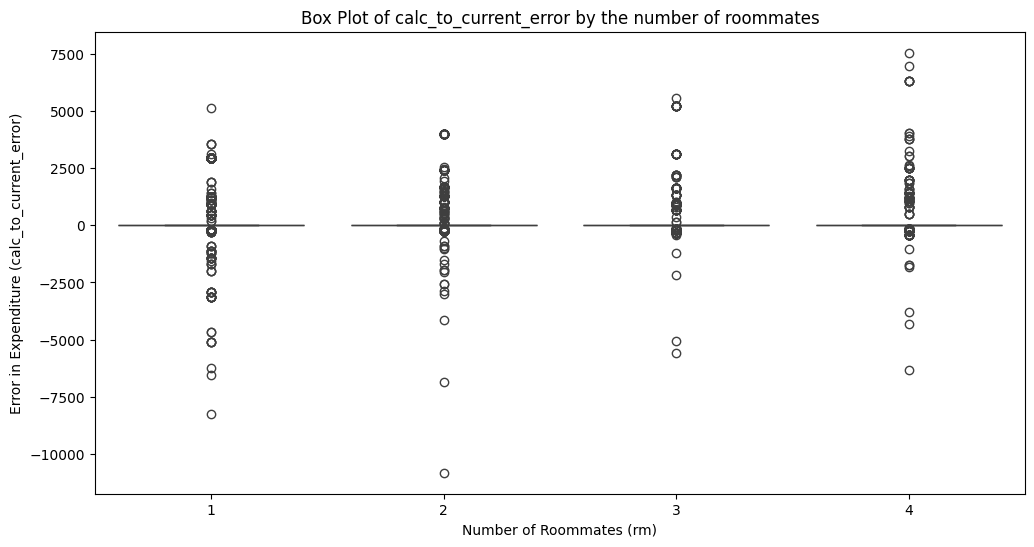

In [ ]:
# Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='rm', y='calc_to_current_error', data=df)
plt.title('Box Plot of calc_to_current_error by the number of roommates')
plt.xlabel('Number of Roommates (rm)')
plt.ylabel('Error in Expenditure (calc_to_current_error)')
plt.show()

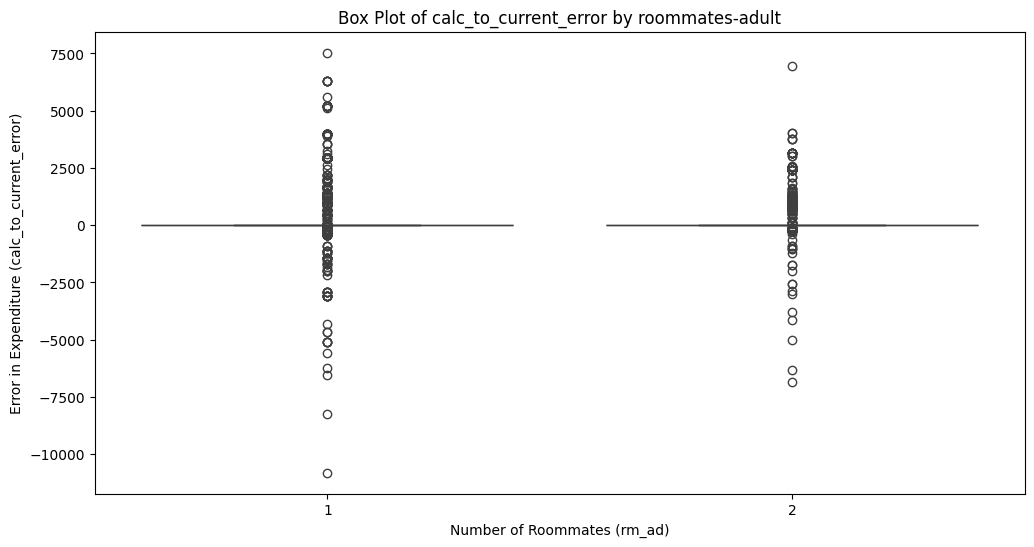

In [ ]:
# Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='rm_ad', y='calc_to_current_error', data=df)
plt.title('Box Plot of calc_to_current_error by roommates-adult')
plt.xlabel('Number of Roommates (rm_ad)')
plt.ylabel('Error in Expenditure (calc_to_current_error)')
plt.show()

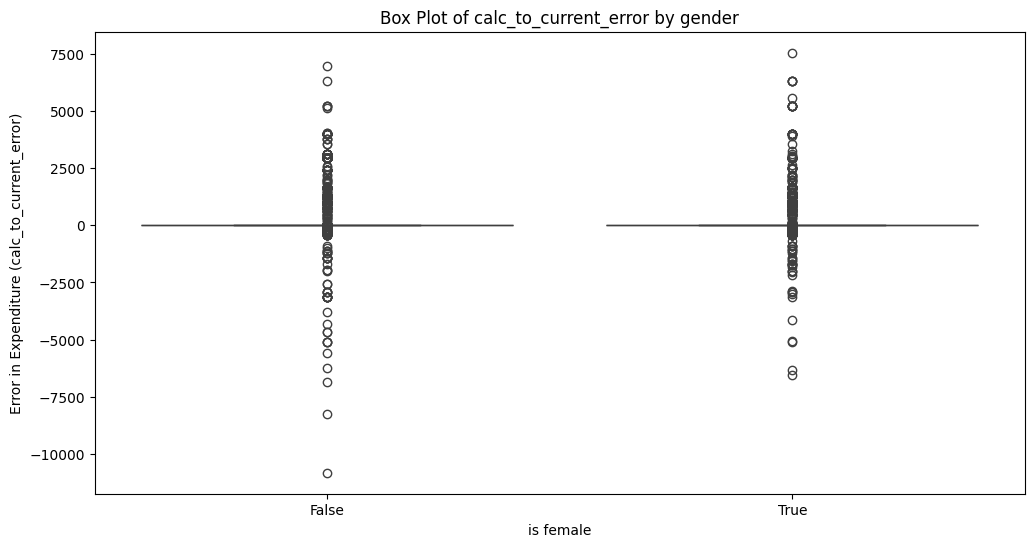

In [ ]:
# Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='is_fem', y='calc_to_current_error', data=df)
plt.title('Box Plot of calc_to_current_error by gender')
plt.xlabel('is female')
plt.ylabel('Error in Expenditure (calc_to_current_error)')
plt.show()

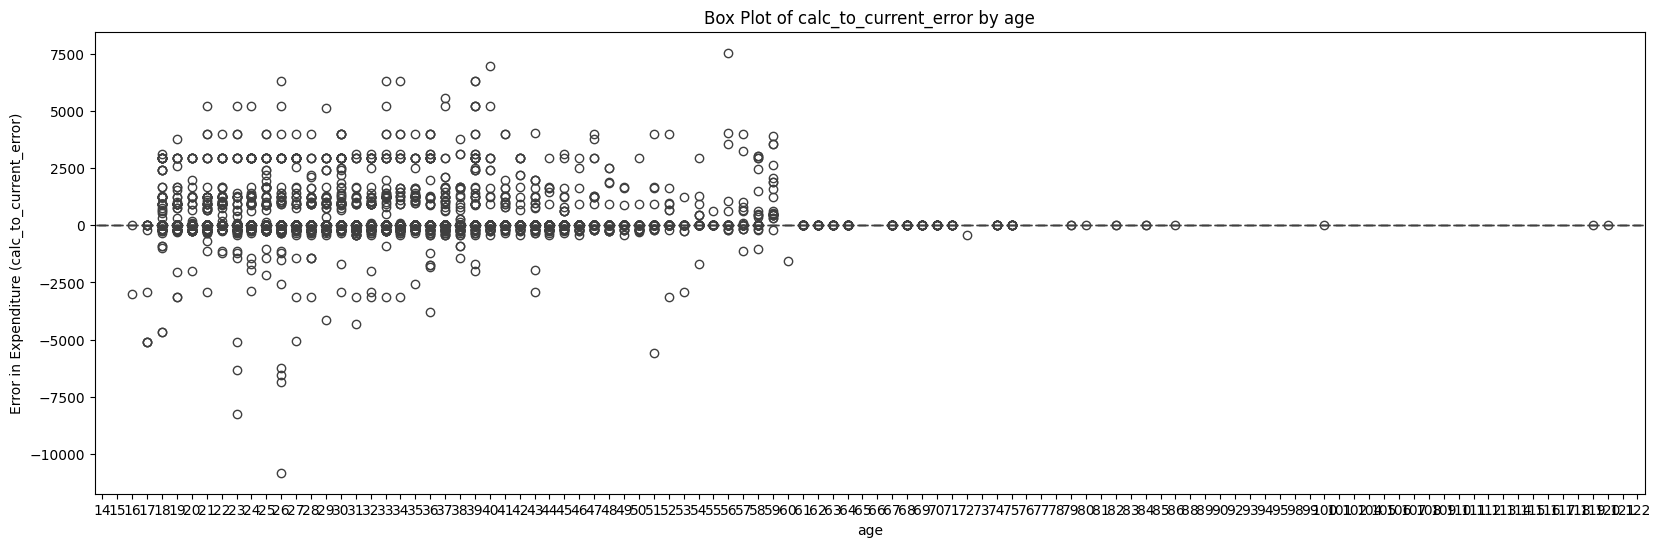

In [ ]:
# Box Plot
plt.figure(figsize=(20, 6))
sns.boxplot(x='age', y='calc_to_current_error', data=df)
plt.title('Box Plot of calc_to_current_error by age')
plt.xlabel('age')
plt.ylabel('Error in Expenditure (calc_to_current_error)')
plt.show()

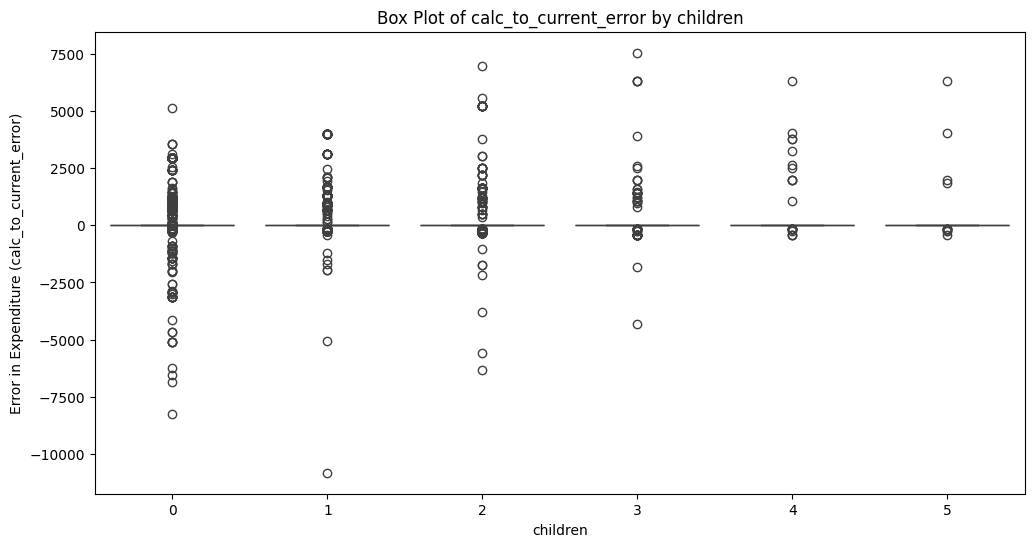

In [ ]:
# Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='children', y='calc_to_current_error', data=df)
plt.title('Box Plot of calc_to_current_error by children')
plt.xlabel('children')
plt.ylabel('Error in Expenditure (calc_to_current_error)')
plt.show()

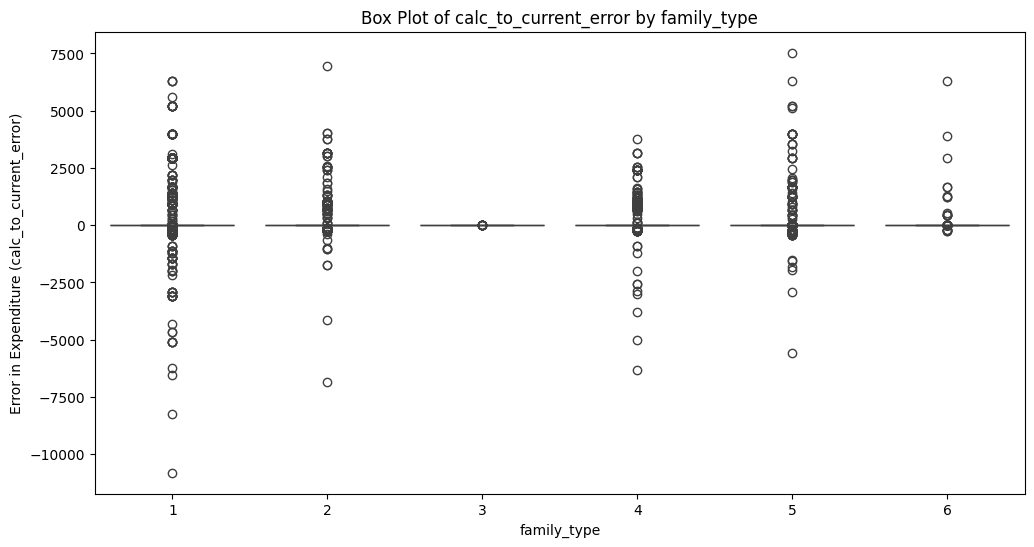

In [ ]:
# Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='family_type', y='calc_to_current_error', data=df)
plt.title('Box Plot of calc_to_current_error by family_type')
plt.xlabel('family_type')
plt.ylabel('Error in Expenditure (calc_to_current_error)')
plt.show()

In [ ]:
df.sample(5)

,population_total,city,id,income_amount,income_type,family_type,expense_amount,expense_debt,education_type,children,upgrade_request_id,date_created,cur_personal_id,is_F,birthdate,age,tenant,city_type,rm_ad,rm,exp_ad,exp_ad_N,accom_costs,accom_costs_N,exp_current,exp_calc,exp_error,exp_calc_N,exp_calc_diff,inc_percent
12503,8849,Tišnov,712565,4000.0,7,1,2000.0,0.0,2,0,915562,2021-06-10,0212174226,False,2002-12-17,18,1,5,1,1,3860,4860,5117,5117,5790,5790.0,0.0,7290.0,1500.0,0.26
49580,915,Třebařov,489627,6000.0,7,1,3000.0,1000.0,1,0,668079,2020-08-30,8353303057,True,1983-03-30,37,1,5,1,1,3860,4860,5117,5117,10907,10907.0,0.0,12407.0,1500.0,0.14
18598,3769,Sázava,756918,11000.0,1,1,7000.0,0.0,4,0,962244,2021-08-01,9005170834,False,1990-05-17,31,1,5,1,1,3860,4860,5117,5117,11486,11486.0,0.0,13136.0,1650.0,0.14
38272,168,Kornatice,523278,10000.0,3,1,8000.0,2000.0,2,1,710737,2020-11-10,9352132141,True,1993-02-13,27,1,5,1,2,3550,4470,7180,7180,18821,18821.5,0.5,20615.5,1794.0,0.10
17543,44824,Přerov,1386039,18000.0,1,4,1000.0,0.0,2,2,1637769,2023-08-05,7055212164,True,1970-05-21,53,1,4,2,4,6750,8510,12507,12507,12652,12652.2,0.2,13813.8,1161.6,0.09


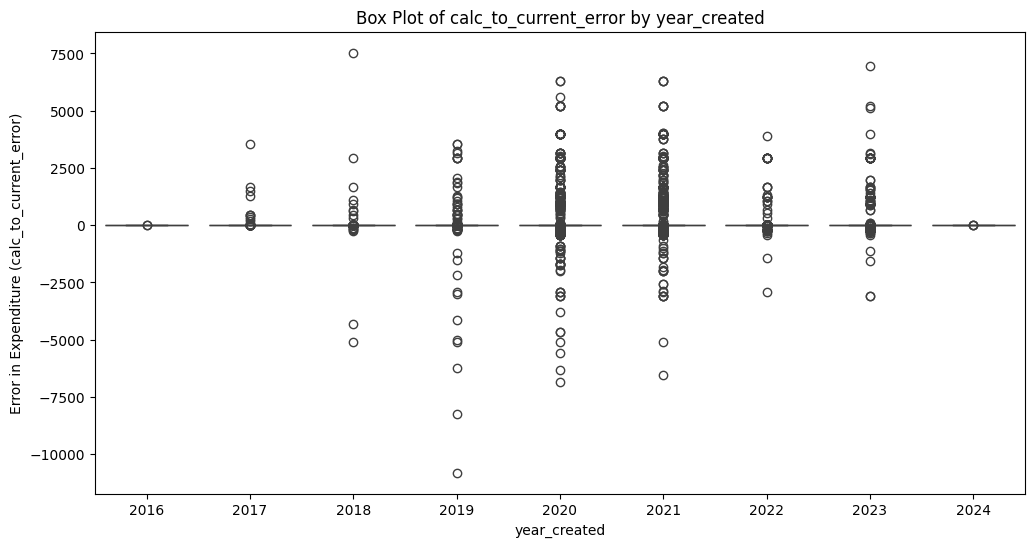

In [ ]:
# Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='yr_cr', y='calc_to_current_error', data=df)
plt.title('Box Plot of calc_to_current_error by year_created')
plt.xlabel('year_created')
plt.ylabel('Error in Expenditure (calc_to_current_error)')
plt.show()

In [ ]:
print(type(df['date_created']))

<class 'pandas.core.series.Series'>


In [ ]:
# Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='date_created', y='calc_to_current_error', data=df)
plt.title('Box Plot of calc_to_current_error by date_created')
plt.xlabel('date_created')
plt.ylabel('Error in Expenditure (calc_to_current_error)')
plt.show()

In [ ]:
df_errors = df[df['calc_to_current_error'].abs() >1]

In [ ]:
df_errors_rm = df_errors['rm'].value_counts()

In [ ]:
print(df_errors_rm)

rm
1    788
2    315
3    225
4    187
Name: count, dtype: int64


In [ ]:
df_errors.sample(20)

,population_total,city,id,income_amount,income_type,family_type,expense_amount,expense_debt,education_type,children,upgrade_request_id,date_cr,yr_cr,cur_personal_id,is_fem,birthdate,age,tenant,city_type,city_type_N,rm_ad,rm,exp_ad,exp_ad_N,accom_costs,accom_costs_N,exp_current,exp_calc,calc_to_current_error,exp_calc_N,new_current_diff,new_current_inc_rate
25602,767,Lhota u Vsetína,600792,75800.0,1,4,9400.0,14700.0,2,1,795890,2021-02-09,2021,9660306238,True,1996-10-30,24,1,5,3,2,3,6750,8510,9712,15299,10078,9937,-141,13373,3295,32.69
37740,167472,Plzeň,561427,23000.0,1,1,5500.0,0.0,1,0,754200,2020-12-29,2020,8711058290,False,1987-11-05,33,1,2,2,1,1,3860,4860,6541,14197,11683,12910,1227,22216,10533,90.16
18510,167472,Plzeň,532133,16000.0,1,1,7000.0,0.0,2,0,721951,2020-11-25,2020,8302212083,False,1983-02-21,37,1,2,2,1,1,3860,4860,6541,14197,11683,12910,1227,22216,10533,90.16
31851,50598,Jihlava,653847,11000.0,5,1,4000.0,1500.0,1,1,853017,2021-04-05,2021,8551112174,True,1985-01-11,36,1,3,3,1,2,3550,4470,8708,13737,16405,17663,1258,24162,7757,47.28
20656,3010,Volyně,550462,20000.0,1,5,5000.0,4000.0,1,0,742780,2020-12-17,2020,7407110502,False,1974-07-11,46,1,5,3,1,1,3860,4860,5117,13737,11683,11486,-197,21756,10073,86.22
39326,1246780,Praha,563613,25000.0,1,4,10000.0,0.0,4,0,756513,2021-01-02,2021,9205160734,False,1992-05-16,28,1,1,1,2,2,6750,8510,11444,16729,11907,13549,1642,18462,6555,55.05
46340,3172,Štěpánkovice,596932,20000.0,1,1,6500.0,3000.0,2,0,791894,2021-02-05,2021,9104165818,False,1991-04-16,29,1,5,3,1,1,3860,4860,5117,13737,11683,11486,-197,21756,10073,86.22
46504,1246780,Praha,596379,30000.0,1,1,18000.0,4000.0,4,0,791303,2021-02-04,2021,0008132454,False,2000-08-13,20,1,1,1,1,1,3860,4860,8233,16729,11683,14602,2919,24748,13065,111.83
36905,1807,Jalubí,524670,20000.0,1,4,18000.0,2000.0,4,1,712515,2020-11-12,2020,9110265219,False,1991-10-26,29,1,5,3,2,3,6750,8510,9712,15299,15117,14906,-211,20060,4943,32.70
34530,2631,Golčův Jeníkov,516398,13000.0,3,2,2500.0,0.0,2,1,701989,2020-10-29,2020,8960280615,True,1989-10-28,31,1,5,3,2,3,6750,8510,9712,15299,11178,11037,-141,14692,3514,31.44


In [ ]:
print(len(df_errors))

1515


In [ ]:
print(len(df))

50000


In [ ]:
fem_count = len(df[df['is_fem'] == 1])

In [ ]:
print(fem_count)

24910


In [ ]:
fem_count_in_error = len(df_errors[df_errors['is_fem'] == 1])

In [ ]:
print(fem_count_in_error)

610


In [ ]:
df_no_error = df[df['calc_to_current_error'].abs() <= 1]

In [ ]:
df_no_error.to_csv('/content/drive/MyDrive/Colab Notebooks/df_clean.csv', index=False)

In [ ]:
print(len(df_no_error))

48485


In [ ]:
print(len(df) - len(df_no_error))

1515


In [ ]:
print(f"The percentage of errors: {len(df_errors) / len(df) * 100:.2f}%")

The percentage of errors: 3.03%


In [ ]:
# Get the list of columns
column_names = list(df_no_error.columns)

# Print the list of columns
print(column_names)

['population_total', 'city', 'id', 'income_amount', 'income_type', 'family_type', 'expense_amount', 'expense_debt', 'education_type', 'children', 'upgrade_request_id', 'date_cr', 'yr_cr', 'cur_personal_id', 'is_fem', 'birthdate', 'age', 'tenant', 'city_type', 'city_type_N', 'rm_ad', 'rm', 'exp_ad', 'exp_ad_N', 'accom_costs', 'accom_costs_N', 'exp_current', 'exp_calc', 'calc_to_current_error', 'exp_calc_N', 'new_current_diff', 'new_current_inc_rate']


In [ ]:
# Columns to drop
cols_to_drop = ['calc_to_current_error']

# Drop the columns
df_analysis = df_no_error.drop(columns=cols_to_drop)

Calculate the average increment and average percentage increment

In [ ]:
# Calculate the average increment
average_increment = df_no_error['new_current_diff'].mean().round(2)

# Calculate the average percentage increment
average_percentage_increment = df_no_error['new_current_inc_rate'].mean().round(2)

print(f"Average Increment: {average_increment}")
print(f"Average Percentage Increment: {average_percentage_increment}%")


Average Increment: 6754.0
Average Percentage Increment: 51.21%


In [ ]:
df_no_error.sample(5)

,population_total,city,id,income_amount,income_type,family_type,expense_amount,expense_debt,education_type,children,upgrade_request_id,date_cr,yr_cr,cur_personal_id,is_fem,birthdate,age,tenant,city_type,city_type_N,rm_ad,rm,exp_ad,exp_ad_N,accom_costs,accom_costs_N,exp_current,exp_calc,calc_to_current_error,exp_calc_N,new_current_diff,new_current_inc_rate
26877,44229,Mladá Boleslav,571388,20000.0,1,1,5000.0,5000.0,2,1,764987,2021-01-13,2021,9651312737,True,1996-01-31,24,1,4,3,1,2,3550,4470,7450,13737,17300,17300,0,25204,7904,45.69
11205,378327,Brno,785764,5.0,6,1,5.0,0.0,1,0,992675,2021-09-01,2021,0308314116,False,2003-08-31,18,1,2,2,1,1,3860,4860,6541,14197,15226,15226,0,25132,9906,65.06
15704,200,Číhaň,749770,15000.0,1,1,5000.0,7000.0,5,2,954692,2021-07-23,2021,8054111989,True,1980-04-11,41,1,5,3,1,3,3550,4470,9712,15299,23555,23556,1,30858,7303,31.00
18167,10200,Nové Město na Moravě,38278,20000.0,1,2,10000.0,0.0,5,2,44504,2018-01-22,2018,8458164781,True,1984-08-16,33,1,4,3,2,4,6750,8510,12507,18477,12652,12652,0,16281,3629,28.68
2568,50330,Teplice,635018,8500.0,6,4,4500.0,2000.0,1,2,832857,2021-03-20,2021,9252163041,True,1992-02-16,29,1,3,3,2,4,6750,8510,14491,18477,16227,16227,0,19514,3287,20.26


Histogram of Increment and Percentage Increment

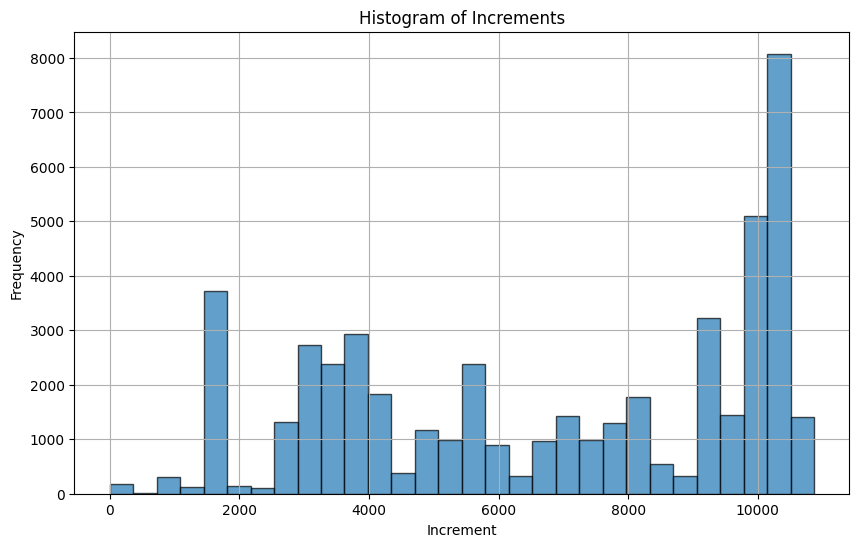

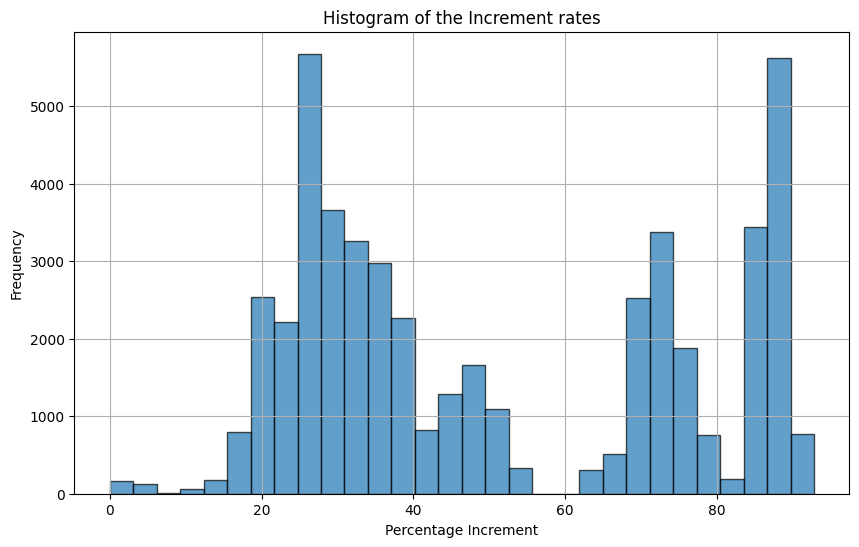

In [ ]:
import matplotlib.pyplot as plt

# Histogram of Increment
plt.figure(figsize=(10, 6))
plt.hist(df_no_error['new_current_diff'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Increments')
plt.xlabel('Increment')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Histogram of Percentage Increment
plt.figure(figsize=(10, 6))
plt.hist(df_no_error['new_current_inc_rate'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of the Increment rates')
plt.xlabel('Percentage Increment')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Box Plot of Increment and Percentage Increment by Year

<Figure size 1000x600 with 0 Axes>

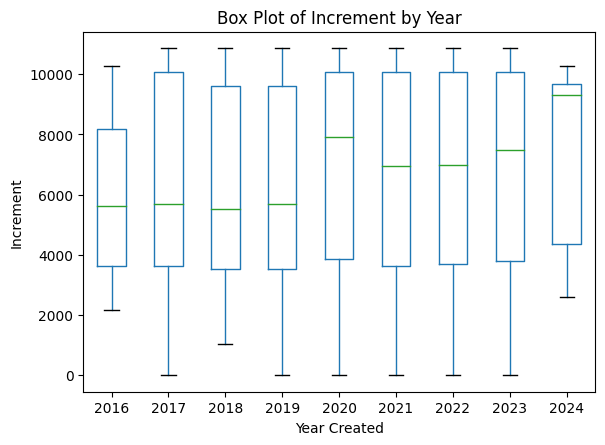

<Figure size 1000x600 with 0 Axes>

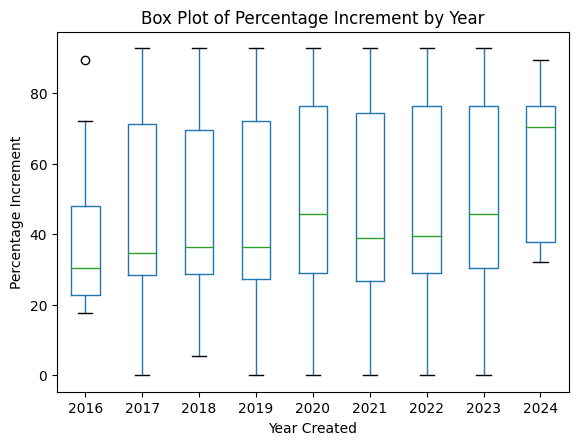

In [ ]:
# Box Plot of Increment by Year
plt.figure(figsize=(10, 6))
df_no_error.boxplot(column='new_current_diff', by='yr_cr', grid=False)
plt.title('Box Plot of Increment by Year')
plt.suptitle('')
plt.xlabel('Year Created')
plt.ylabel('Increment')
plt.show()

# Box Plot of Percentage Increment by Year
plt.figure(figsize=(10, 6))
df_no_error.boxplot(column='new_current_inc_rate', by='yr_cr', grid=False)
plt.title('Box Plot of Percentage Increment by Year')
plt.suptitle('')
plt.xlabel('Year Created')
plt.ylabel('Percentage Increment')
plt.show()


In [ ]:
# Scatter Plot of Increment and Percentage Increment

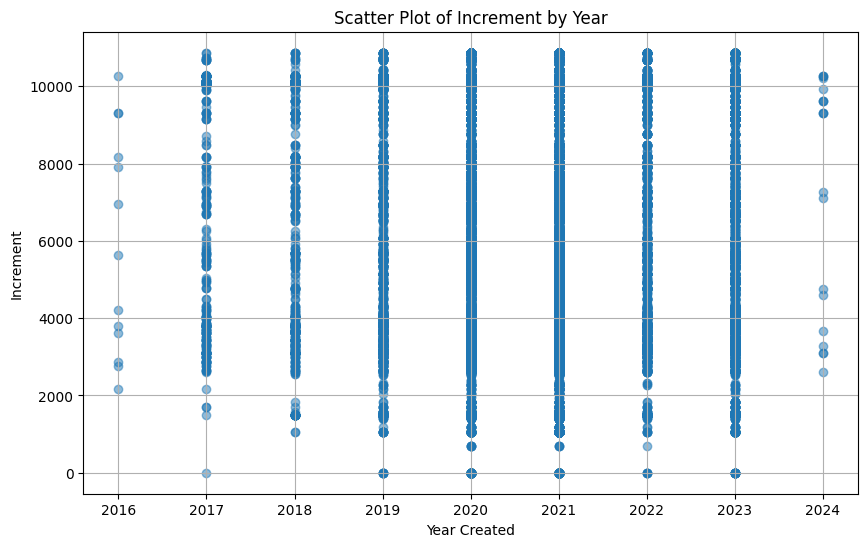

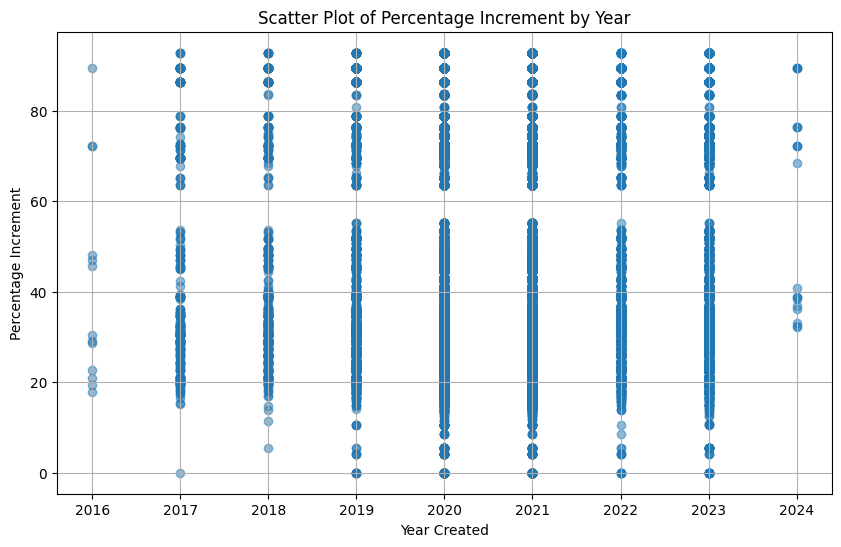

In [ ]:
# Scatter Plot of Increment
plt.figure(figsize=(10, 6))
plt.scatter(df_no_error['yr_cr'], df_no_error['new_current_diff'], alpha=0.5)
plt.title('Scatter Plot of Increment by Year')
plt.xlabel('Year Created')
plt.ylabel('Increment')
plt.grid(True)
plt.show()

# Scatter Plot of Percentage Increment
plt.figure(figsize=(10, 6))
plt.scatter(df_no_error['yr_cr'], df_no_error['new_current_inc_rate'], alpha=0.5)
plt.title('Scatter Plot of Percentage Increment by Year')
plt.xlabel('Year Created')
plt.ylabel('Percentage Increment')
plt.grid(True)
plt.show()
